<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

# Training Notebook

# RSNA 2023 Abdominal Trauma Detection with [KerasCV](https://github.com/keras-team/keras-cv) and [KerasCore](https://github.com/keras-team/keras-core)

This notebook walks you through how to train a **Convolutional Neural Network (CNN)** model using Keras (Core and CV) on the RSNA 2023 Abdominal Trauma Detection dataset made available for this competition.

Fun fact: This notebook is backend (tensorflow, pytorch, jax) agnostic. Using KerasCV and KerasCore we can choose a backend of our choise! Feel free to read [Keras Core](https://keras.io/keras_core/announcement/) announcement to know more about Keras.

In this notebook you will learn:

* Loading the data using [`tf.data`](https://www.tensorflow.org/guide/data).
* Applying augmentations inside the data pipeline.
* Create the model using KerasCV presets.
* Train the model.
* Visualize the training plots.

## Notebooks

For this competition we have two starter notebook. This notebook (you are reading) trains the model on the dataset, while there lies another notebook that performs inference and submits to the competition.

1. [**Training Kernel**](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-train)
2. [**Inference Kernel**](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-infer)

**Note**: [KerasCV guides](https://keras.io/guides/keras_cv/) is the place to go for a deeper understanding of KerasCV individually.

# Setup and Imports

We will need KerasCV for this notebook.

Feel free to use `pip install keras-cv` instead of the installation from github.

In [1]:
! pip install -q git+https://github.com/keras-team/keras-cv
# !pip install keras-cv

In [2]:
import os
# You can use `tensorflow`, `pytorch`, `jax` here
# KerasCore makes the notebook backend agnostic :)
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras_core as keras
from keras_core import layers

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


# Configuration

A particularly good practise is to have a configuration class for your notebooks. This not only keeps your configurations all at a single place but also becomes handy to map the configs to the performance of the model.

Please play around with the configurations and see how the performance of the model changes.

## Note on some observations

Reference Notebook: https://www.kaggle.com/code/aritrag/eda-train-csv

1. Class Dependencies: Refers to inherent relationships between classes in the analysis.
2. Complementarity: `bowel_injury` and `bowel_healthy`, as well as `extravasation_injury` and `extravasation_healthy`, are perfectly complementary, with their sum always equal to 1.0.
3. Simplification: For the model, only `{bowel/extravasation}_injury` will be included, and the corresponding healthy status can be calculated using a sigmoid function.
4. Softmax: `{kidney/liver/spleen}_{healthy/low/high}` classifications are softmaxed, ensuring their combined probabilities sum up to 1.0 for each organ, simplifying the model while preserving essential information.

In [3]:
class Config:
    SEED = 42
#     IMAGE_SIZE = [256, 256]
    IMAGE_SIZE = [224, 224]

    BATCH_SIZE = 64
    EPOCHS = 10
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

# Reproducibility

We would want this notebook to have reproducible results. Here we set the seed for all the random algorithms so that we can reproduce the experiments each time exactly the same way.

In [4]:
keras.utils.set_random_seed(seed=config.SEED)

# Dataset

The dataset provided in the competition consists of DICOM images. We will not be training on the DICOM images, rather would work on PNG image which are extracted from the DICOM format.

[A helpful resource on the conversion of DICOM to PNG](https://www.kaggle.com/code/radek1/how-to-process-dicom-images-to-pngs)

In [5]:
BASE_PATH = f"/kaggle/input/rsna-atd-512x512-png-v2-dataset"

## Meta Data

The `train.csv` file contains the following meta information:

- `patient_id`: A unique ID code for each patient.
- `series_id`: A unique ID code for each scan.
- `instance_number`: The image number within the scan. The lowest instance number for many series is above zero as the original scans were cropped to the abdomen.
- `[bowel/extravasation]_[healthy/injury]`: The two injury types with binary targets.
- `[kidney/liver/spleen]_[healthy/low/high]`: The three injury types with three target levels.
- `any_injury`: Whether the patient had any injury at all.


In [6]:
# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

dataframe.head(2)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512


We split the training dataset into train and validation. This is a common practise in the Machine Learning pipelines. We not only want to train our model, but also want to validate it's training.

A small catch here is that the training and validation data should have an aligned data distribution. Here we handle that by grouping the lables and then splitting the dataset. This ensures an aligned data distribution between the training and the validation splits.

In [7]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [8]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

## Data Pipeline /w tf.data

Here we build the data pipeline using `tf.data`. Using `tf.data` we can map out data to an augmentation pipeline simple by using the ` map` API.

Adding augmentations to the data pipeline is as simple as adding a layer into the list of layers that the `Augmenter` processes.

Reference: https://keras.io/api/keras_cv/layers/augmentation/

In [9]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    
    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    return (image, labels)


def apply_augmentation(images, labels):
    augmenter = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),            
        ]
    )
    return (augmenter(images), labels)


def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [10]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([64, 224, 224, 3]),
 [TensorShape([64, 1]),
  TensorShape([64, 1]),
  TensorShape([64, 3]),
  TensorShape([64, 3]),
  TensorShape([64, 3])])

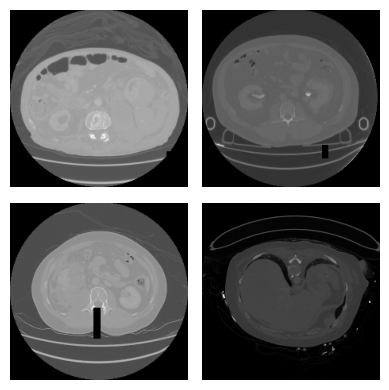

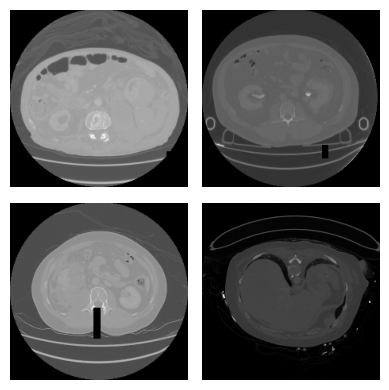

In [11]:
# No more customizing your plots by hand, KerasCV has your back ;)
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=2,
    cols=2,
)

# Build Model

We are going to load a pretrained model from the [list of avaiable backbones in KerasCV](https://keras.io/api/keras_cv/models/backbones/). We are using the `ResNetBackbone` as our backbone. The practise of using a pretrained model and finetuning it to a specific dataset is prevalent in the DL community.

We use the [Functional API](https://keras.io/guides/functional_api/) of Keras to build the model. The design of the model would be such that we input a single image and we get different heads for the various predictions we need (kidney, spleen...).

We have also added a Learning Rate scheduler for you to work with. When an athlete trains, the first step is always to warm up. We take a similar approach to training our models. We warm up with model where the learning rate increses from the initial LR to a higher LR. After the warmup stage we provide a decay algorithm (cosine here). A list of all the learning rate scheduler can be found [here](https://keras.io/api/optimizers/learning_rate_schedules/).

In [12]:
def build_model(warmup_steps, decay_steps):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)
    
    # Define Backbone
#     backbone = keras_cv.models.ResNetBackbone.from_preset("resnet50_imagenet")
#     backbone.include_rescaling = False
#     x = backbone(inputs)
    
    backbone = keras.applications.vgg16.VGG16(include_top="False", weights="imagenet", pooling="avg")
    x = backbone(inputs)
    # GAP to get the activation maps
#     gap = keras.layers.GlobalAveragePooling2D()
#     x = gap(x)

    # Define 'necks' for each head
    x_bowel = keras.layers.Dense(32, activation='silu')(x)
    x_extra = keras.layers.Dense(32, activation='silu')(x)
    x_liver = keras.layers.Dense(32, activation='silu')(x)
    x_kidney = keras.layers.Dense(32, activation='silu')(x)
    x_spleen = keras.layers.Dense(32, activation='silu')(x)

    # Define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra) # use sigmoid to convert predictions to [0-1]
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney) # use softmax for the kidney head
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen) # use softmax for the spleen head
    
    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print("[INFO] Building the model...")
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel":keras.losses.BinaryCrossentropy(),
        "extra":keras.losses.BinaryCrossentropy(),
        "liver":keras.losses.CategoricalCrossentropy(),
        "kidney":keras.losses.CategoricalCrossentropy(),
        "spleen":keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "bowel":["accuracy"],
        "extra":["accuracy"],
        "liver":["accuracy"],
        "kidney":["accuracy"],
        "spleen":["accuracy"],
    }
    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
      loss=loss,
      metrics=metrics
    )
    
    return model

# Train the model with "model.fit"

In [13]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=96640
warmup_steps=9664
decay_steps=86976


In [14]:
# build the model
print("[INFO] Building the model...")
model = build_model(warmup_steps, decay_steps)

# train
print("[INFO] Training...")
history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
)

[INFO] Building the model...
553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
[INFO] Building the model...
[INFO] Compiling the model...
[INFO] Training...
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - bowel_accuracy: 0.8087 - extra_accuracy: 0.8256 - kidney_accuracy: 0.7664 - liver_accuracy: 0.2532 - loss: 4.6186 - spleen_accuracy: 0.3624 - val_bowel_accuracy: 0.4795 - val_extra_accuracy: 0.6967 - val_kidney_accuracy: 0.8113 - val_liver_accuracy: 0.8697 - val_loss: 4.4638 - val_spleen_accuracy: 0.6773
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - bowel_accuracy: 0.8211 - extra_accuracy: 0.8523 - kidney_accuracy: 0.7906 - liver_accuracy: 0.7071 - loss: 4.4033 - spleen_accuracy: 0.6163 - val_bowel_accuracy: 0.4795 - val_extra_accuracy: 0.6967 - val_kidney_accuracy: 0.8113 - val_liver_accuracy: 0.8697 - val_loss: 4.2017 - val_spleen_accuracy: 0.6773
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 150s 969ms/step - bowel_accuracy: 0.8211 - extra_accuracy: 0.8523 - kidney_acc

## Visualize the training plots

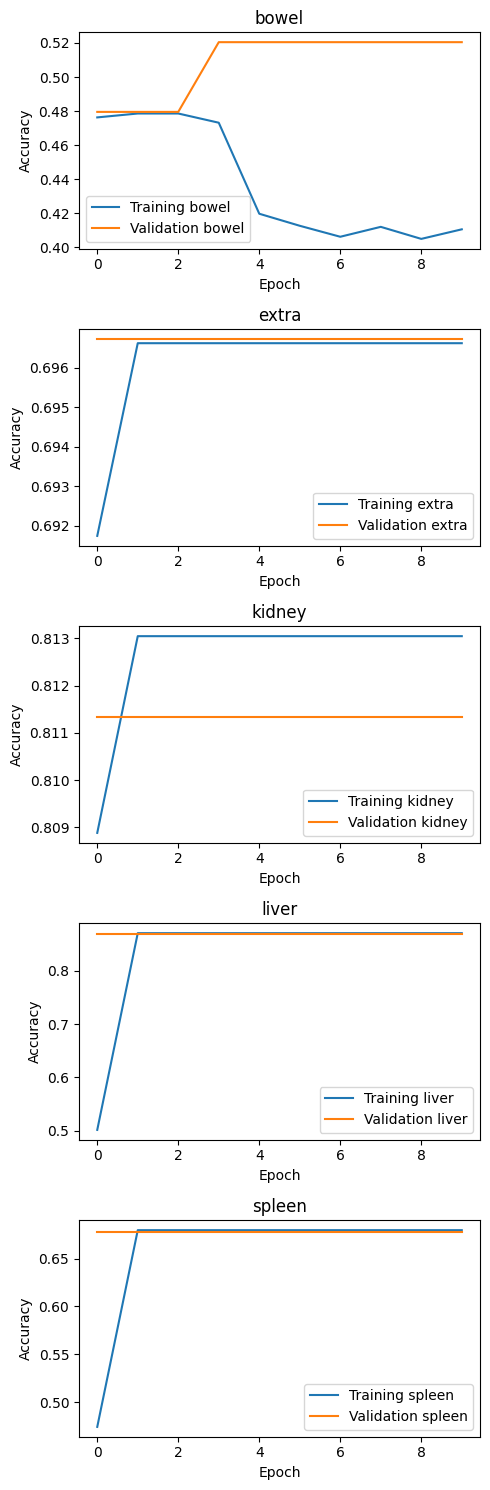

In [15]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

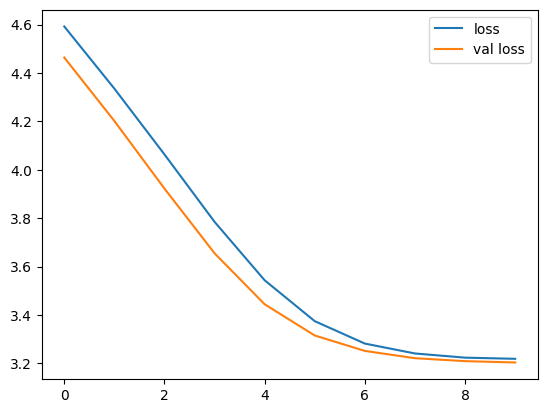

In [16]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [17]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 3.204
>>>> BEST Acc   : 0.715
>>>> BEST Epoch : 9

ORGAN Acc:
  >>>> Bowel           : 0.520
  >>>> Extravasation   : 0.697
  >>>> Liver           : 0.870
  >>>> Kidney          : 0.811
  >>>> Spleen          : 0.677


## Store the model for inference

In [18]:
# Save the model
model.save("rsna-atd_v2.keras")

# Next Steps

1. Please refer to the [Inference Notebook](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-infer) to learn about submitting to the competition
2. Dive deep into [KerasCV](https://github.com/keras-team/keras-cv) and [KerasCore](https://github.com/keras-team/keras-core)

# Credits

This notebook was forked from https://www.kaggle.com/code/awsaf49/rsna-atd-cnn-tpu-train